# Waste Classification with Transfer Learning (MobileNetV2)

Notebook phân loại rác **Organic / Recyclable** sử dụng **Transfer Learning** với MobileNetV2:

- Đọc dữ liệu từ thư mục local trong cùng folder
- Data augmentation + `preprocess_input` của MobileNetV2
- Huấn luyện 2 pha: train head, sau đó fine-tune backbone
- Callback: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- Đánh giá bằng classification report + confusion matrix


In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

print('TensorFlow version:', tf.__version__)

# Nếu có GPU thì bật memory growth để tránh lỗi OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
        print('Enabled GPU memory growth')
    except Exception as e:
        print('Could not set memory growth:', e)


TensorFlow version: 2.19.0


In [2]:
# Thư mục DATASET nằm cùng cấp với notebook
BASE_DIR = '../DATASET'
train_path = os.path.join(BASE_DIR, 'TRAIN')
test_path = os.path.join(BASE_DIR, 'TEST')

print('Train path:', train_path)
print('Test path :', test_path)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


Train path: ../DATASET\TRAIN
Test path : ../DATASET\TEST


In [3]:
train_classes = sorted([
    d for d in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, d))
])
print('Classes:', train_classes)

train_counts = {
    c: len(os.listdir(os.path.join(train_path, c)))
    for c in train_classes
}
test_counts = {
    c: len(os.listdir(os.path.join(test_path, c)))
    for c in train_classes
}

count_df = pd.DataFrame({'train': train_counts, 'test': test_counts})
count_df


Classes: ['O', 'R']


,train,test
O,12565,1401
R,9999,1112


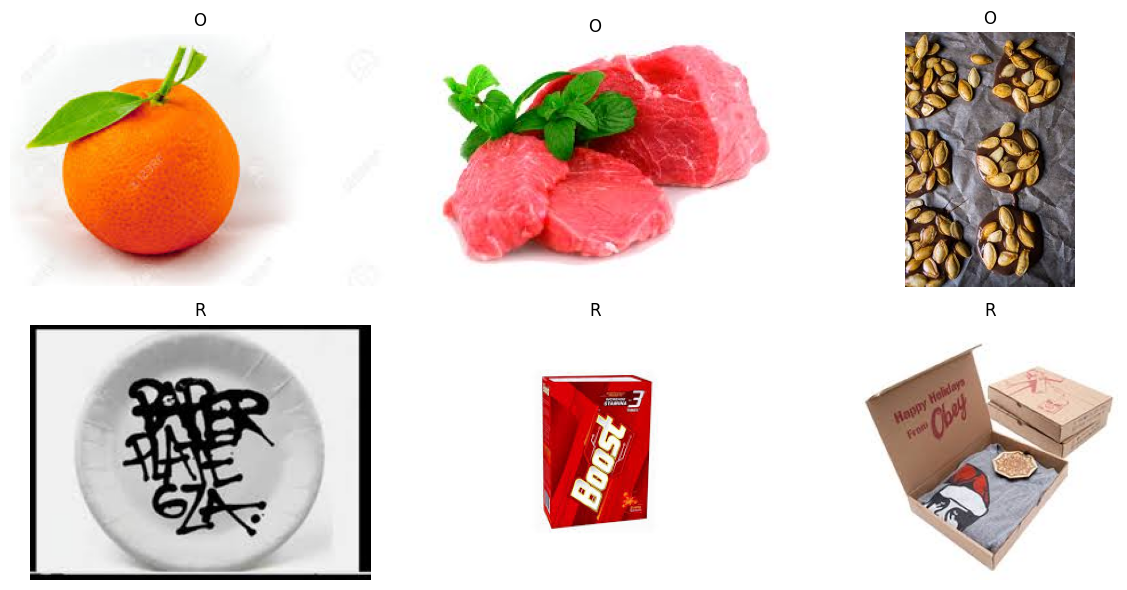

In [4]:
def show_sample_images(num_per_class=3):
    plt.figure(figsize=(12, 6))
    idx = 1

    for cls in train_classes:
        cls_dir = os.path.join(train_path, cls)
        files = os.listdir(cls_dir)
        random.shuffle(files)
        samples = files[:num_per_class]

        for fname in samples:
            img_path = os.path.join(cls_dir, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(train_classes), num_per_class, idx)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
            idx += 1

    plt.tight_layout()

show_sample_images(num_per_class=3)


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print('Class indices:', class_indices)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Class indices: {'O': 0, 'R': 1}


In [6]:
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Đóng băng backbone ban đầu (chỉ train phần head)
base_model.trainable = False
print('Base model trainable:', base_model.trainable)

inputs = Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs, name='mobilenetv2_waste_classifier')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# (Tuỳ chọn) Vẽ model
# plot_model(model, to_file='waste_model_architecture.png', show_shapes=True, dpi=72)


Base model trainable: False


Model: "mobilenetv2_waste_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
EPOCHS = 30

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='waste_mobilenetv2_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


In [8]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks
)


Epoch 1/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.7852 - loss: 0.4653
Epoch 1: val_loss improved from None to 0.28265, saving model to waste_mobilenetv2_best.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 596s 837ms/step - accuracy: 0.8585 - loss: 0.3335 - val_accuracy: 0.8683 - val_loss: 0.2827 - learning_rate: 1.0000e-04
Epoch 2/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9075 - loss: 0.2381
Epoch 2: val_loss improved from 0.28265 to 0.24796, saving model to waste_mobilenetv2_best.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 399s 565ms/step - accuracy: 0.9099 - loss: 0.2322 - val_accuracy: 0.8882 - val_loss: 0.2480 - learning_rate: 1.0000e-04
Epoch 3/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9164 - loss: 0.2158
Epoch 3: val_loss did not improve from 0.24796
706/706 ━━━━━━━━━━━━━━━━━━━━ 401s 568ms/step - accuracy: 0.9197 - loss: 0.2091 - val_accuracy: 0.8770 - val_loss: 0.2578 - learning_rate: 1.0000e-04
Epoch 4/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/st

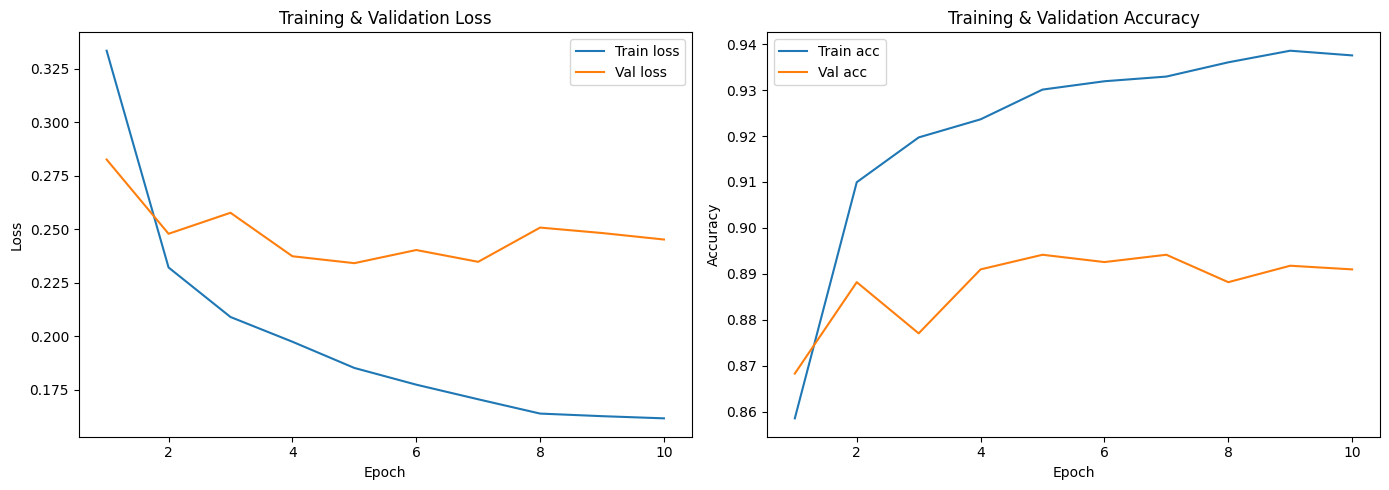

In [9]:
def plot_history(h):
    hist = h.history
    epochs_range = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, hist['loss'], label='Train loss')
    plt.plot(epochs_range, hist['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, hist['accuracy'], label='Train acc')
    plt.plot(epochs_range, hist['val_accuracy'], label='Val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.tight_layout()

plot_history(history)


In [10]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f'Test loss: {test_loss:.4f}')
print(f'Test acc : {test_acc:.4f}')


79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.8942 - loss: 0.2342
Test loss: 0.2342
Test acc : 0.8942


In [11]:
# Fine-tuning: mở một phần backbone để train thêm
fine_tune_at = len(base_model.layers) - 40  # có thể chỉnh tuỳ GPU

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

print('Number of layers in the base model:', len(base_model.layers))
print('Trainable layers after unfreezing:')
print(sum(1 for l in base_model.layers if l.trainable))

# Compile lại với learning rate nhỏ hơn
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = len(history.epoch) + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=len(history.epoch),
    validation_data=test_generator,
    callbacks=callbacks
)

plot_history(history_fine)


Number of layers in the base model: 154
Trainable layers after unfreezing:
40
Epoch 11/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9050 - loss: 0.2351
Epoch 11: val_loss improved from 0.23423 to 0.23290, saving model to waste_mobilenetv2_best.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 482s 670ms/step - accuracy: 0.9134 - loss: 0.2172 - val_accuracy: 0.8965 - val_loss: 0.2329 - learning_rate: 1.0000e-05
Epoch 12/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9279 - loss: 0.1782
Epoch 12: val_loss did not improve from 0.23290
706/706 ━━━━━━━━━━━━━━━━━━━━ 451s 638ms/step - accuracy: 0.9306 - loss: 0.1758 - val_accuracy: 0.8707 - val_loss: 0.2882 - learning_rate: 1.0000e-05
Epoch 13/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9360 - loss: 0.1725
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 13: val_loss did not improve from 0.23290
706/706 ━━━━━━━━━━━━━━━━━━━━ 453s 641ms/step - accuracy: 0.9381 - loss: 0.1665 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
test_loss_ft, test_acc_ft = model.evaluate(test_generator, verbose=1)
print(f'Test loss (fine-tuned): {test_loss_ft:.4f}')
print(f'Test acc  (fine-tuned): {test_acc_ft:.4f}')

model.save('waste_mobilenetv2_final.keras')
print('Model saved to waste_mobilenetv2_final.keras')


79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 334ms/step - accuracy: 0.8965 - loss: 0.2329
Test loss (fine-tuned): 0.2329
Test acc  (fine-tuned): 0.8965
Model saved to waste_mobilenetv2_final.keras


79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 344ms/step
Classification report:
              precision    recall  f1-score   support

           O       0.86      0.98      0.91      1401
           R       0.96      0.80      0.87      1112

    accuracy                           0.90      2513
   macro avg       0.91      0.89      0.89      2513
weighted avg       0.90      0.90      0.89      2513



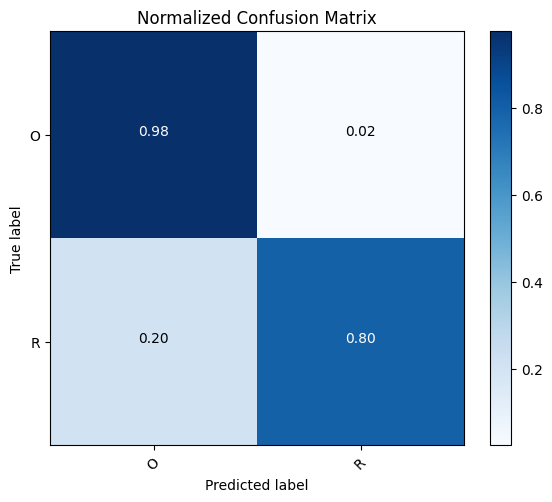

In [13]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

print('Classification report:')
print(classification_report(
    y_true,
    y_pred,
    target_names=[idx_to_class[i] for i in range(num_classes)]
))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
plt.imshow(cm_norm, interpolation='nearest', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [idx_to_class[i] for i in range(num_classes)], rotation=45)
plt.yticks(tick_marks, [idx_to_class[i] for i in range(num_classes)])

thresh = cm_norm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(
            j, i,
            f'{cm_norm[i, j]:.2f}',
            horizontalalignment='center',
            color='white' if cm_norm[i, j] > thresh else 'black'
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()


Test image path: ../DATASET\TEST\O\O_13943.jpg
True class: O - filename: O_13943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted: O (99.98%)


('O', 0.9997586607933044)

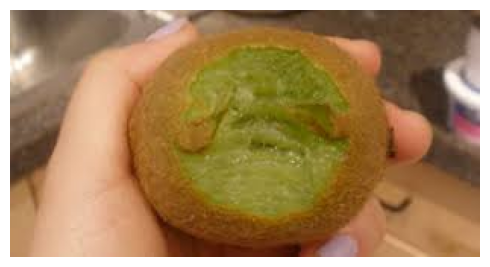

In [39]:
def predict_func(img_bgr, show=True):
    """img_bgr: ảnh đọc bằng cv2.imread (BGR)"""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    if show:
        plt.figure(figsize=(5, 4))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.tight_layout()

    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_array = img_resized.astype('float32')
    img_array = np.expand_dims(img_array, axis=0)

    img_array = preprocess_input(img_array)
    preds = model.predict(img_array)
    class_idx = int(np.argmax(preds, axis=1)[0])
    prob = float(np.max(preds))

    class_name = idx_to_class[class_idx]
    print(f'Predicted: {class_name} ({prob * 100:.2f}%)')

    return class_name, prob


def get_random_test_image(class_name=None):
    if class_name is None:
        class_name = random.choice(list(idx_to_class.values()))
    cls_dir = os.path.join(test_path, class_name)
    files = [f for f in os.listdir(cls_dir) if not f.startswith('.')]
    fname = random.choice(files)
    img_path = os.path.join(cls_dir, fname)
    print('Test image path:', img_path)
    img = cv2.imread(img_path)
    return img, class_name, fname


img, cls, fname = get_random_test_image()
print('True class:', cls, '- filename:', fname)
predict_func(img, show=True)
